In [1]:
# !pip install  kagglehub  --upgrade
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images")

print("Path to dataset files:", path)

Path to dataset files: /home/simon/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1


In [2]:
import os
import tensorflow as tf

# Set the number of threads
num_threads = os.cpu_count()  # or manually set e.g., 8
print(num_threads)
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout


2025-08-05 13:56:52.355125: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 13:56:52.461776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754398612.519669  277786 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754398612.533660  277786 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754398612.615997  277786 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

16


# Loading the data set



## Dataset properties

In [25]:
# Training set

path_train = path+'/melanoma_cancer_dataset/train'

# Define paths for benign and malignant image directories
path_benign = os.path.join(path_train, 'benign')
path_malignant = os.path.join(path_train, 'malignant')

# Initialize empty lists to store file paths and corresponding labels
files = []
labels = []

# Process all images in the "benign" directory
for filename in os.listdir(path_benign):
    # Check if the file is an image (JPEG or PNG)
    if filename.lower().endswith(('.jpg', '.png')):  
        files.append(os.path.join(path_benign, filename))  # Store full image path
        labels.append('benign')  # Store the corresponding label

# Process all images in the "malignant" directory
for filename in os.listdir(path_malignant):
    # Check if the file is an image (JPEG or PNG)
    if filename.lower().endswith(('.jpg', '.png')):  
        files.append(os.path.join(path_malignant, filename))  # Store full image path
        labels.append('malignant')  # Store the corresponding label

# Create a Pandas DataFrame with image file paths and their corresponding labels
train_df = pd.DataFrame({
    'file_path': files,
    'label': labels
})

# Display the first few rows of the DataFrame to verify correctness
train_df.shape


# class distribution in train_df
print("\nClass distribution in train_df:")
train_df['label'].value_counts()





Class distribution in train_df:


label
benign       5000
malignant    4604
Name: count, dtype: int64

In [26]:
# Testing set
path_test = path+'/melanoma_cancer_dataset/test'
# Define paths for benign and malignant image directories
path_benign = os.path.join(path_test, 'benign')
path_malignant = os.path.join(path_test, 'malignant')

# Initialize empty lists to store file paths and corresponding labels
files = []
labels = []

# Process all images in the "benign" directory
for filename in os.listdir(path_benign):
    # Check if the file is an image (JPEG or PNG)
    if filename.lower().endswith(('.jpg', '.png')):  
        files.append(os.path.join(path_benign, filename))  # Store full image path
        labels.append('benign')  # Store the corresponding label

# Process all images in the "malignant" directory
for filename in os.listdir(path_malignant):
    # Check if the file is an image (JPEG or PNG)
    if filename.lower().endswith(('.jpg', '.png')):  
        files.append(os.path.join(path_malignant, filename))  # Store full image path
        labels.append('malignant')  # Store the corresponding label

# Create a Pandas DataFrame with image file paths and their corresponding labels
test_df = pd.DataFrame({
    'file_path': files,
    'label': labels
})

# Display the first few rows of the DataFrame to verify correctness
test_df.shape

# class distribution in train_df
print("\nClass distribution in test_df:")
test_df['label'].value_counts()




Class distribution in test_df:


label
benign       500
malignant    500
Name: count, dtype: int64

### Sizes

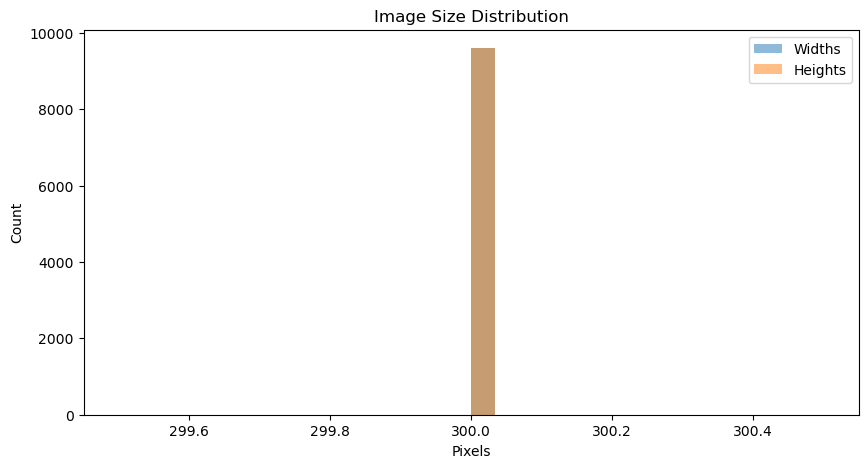

In [27]:
from PIL import Image
import matplotlib.pyplot as plt

# Get image sizes
sizes = [Image.open(fp).size for fp in train_df['file_path']]
widths, heights = zip(*sizes)

plt.figure(figsize=(10,5))
plt.hist(widths, bins=30, alpha=0.5, label='Widths')
plt.hist(heights, bins=30, alpha=0.5, label='Heights')
plt.title("Image Size Distribution")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.show()


### Color distribution

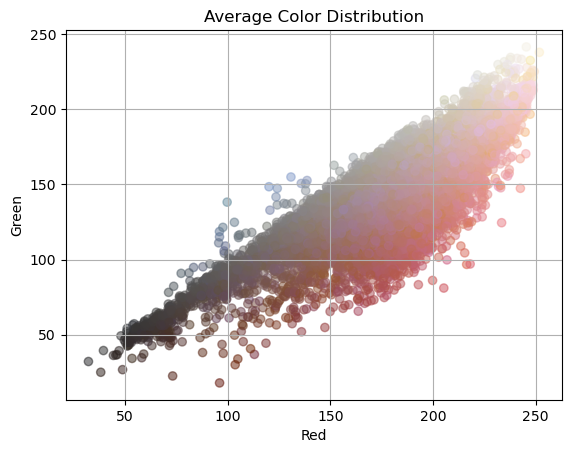

In [6]:
import numpy as np

def average_rgb(img_path):
    img = Image.open(img_path).convert('RGB').resize((64, 64))
    return np.array(img).mean(axis=(0,1))

colors = np.array([average_rgb(fp) for fp in train_df['file_path']])
plt.scatter(colors[:,0], colors[:,1], c=colors/255, alpha=0.5)
plt.xlabel("Red")
plt.ylabel("Green")
plt.title("Average Color Distribution")
plt.grid()
plt.show()


In [7]:
from tqdm import tqdm

def is_valid_image(fp):
    try:
        Image.open(fp).verify()
        return True
    except:
        return False

train_df['valid'] = [is_valid_image(fp) for fp in tqdm(train_df['file_path'])]
print("Corrupt images:", (~train_df['valid']).sum())


100%|██████████| 9605/9605 [00:00<00:00, 18994.98it/s]

Corrupt images: 0


### Show random examples

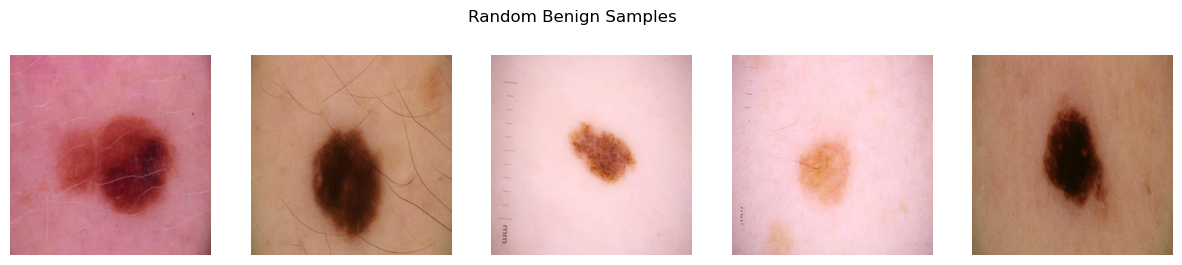

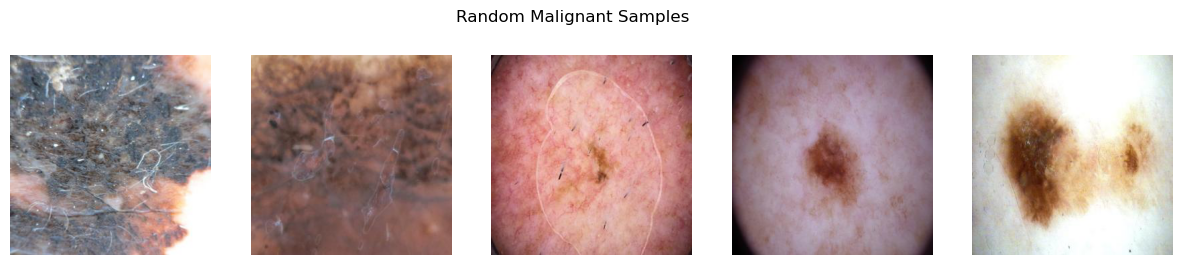

In [28]:
import random

def show_random_samples(df, label, n=5):
    sample_paths = random.sample(df[df['label'] == label]['file_path'].tolist(), n)
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for ax, img_path in zip(axes, sample_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(f"Random {label.capitalize()} Samples")
    plt.show()

show_random_samples(train_df, 'benign')
show_random_samples(train_df, 'malignant')


### CHeck duplicates

100%|██████████| 9604/9604 [00:13<00:00, 690.32it/s]

Found 46 images with duplicate hash values.


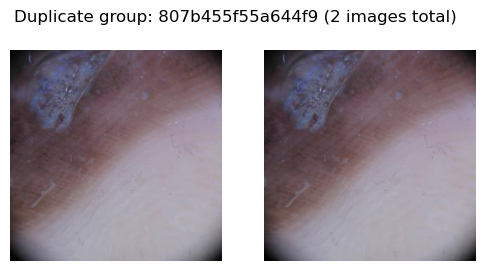

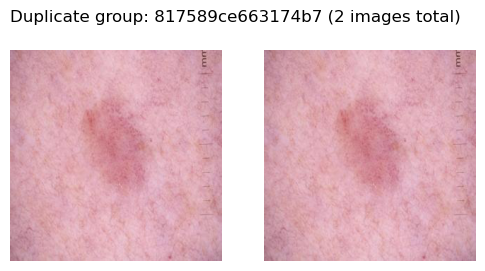

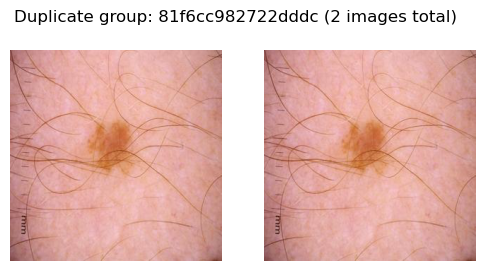

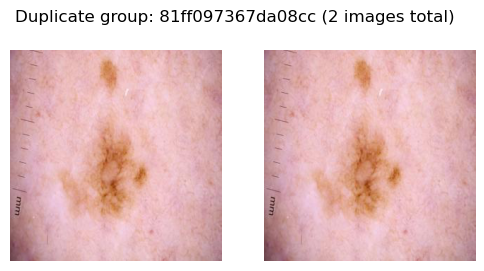

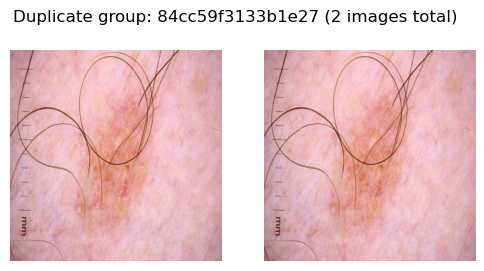

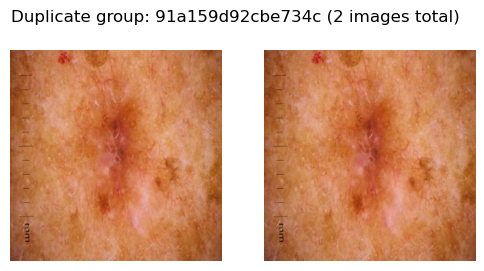

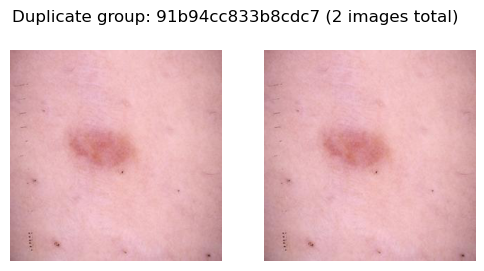

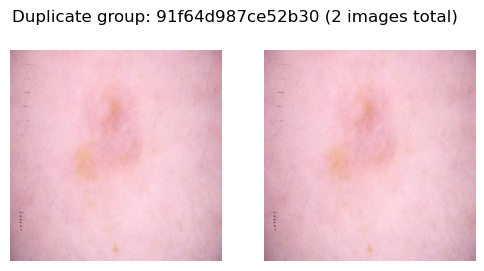

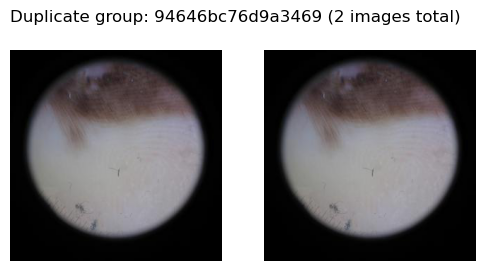

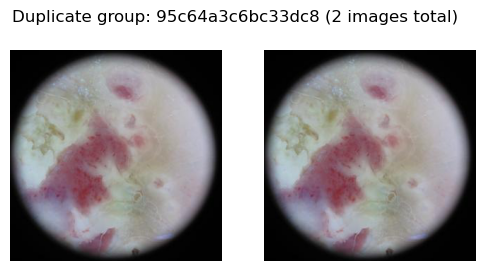

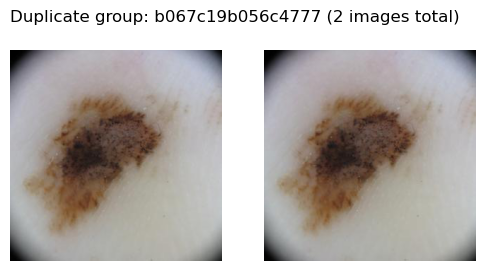

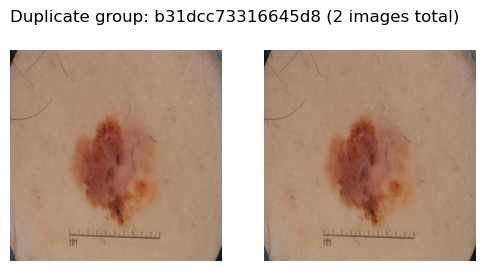

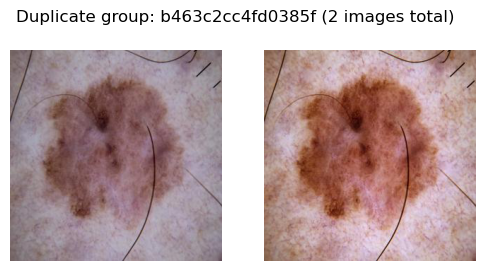

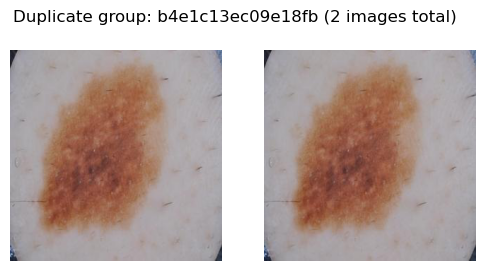

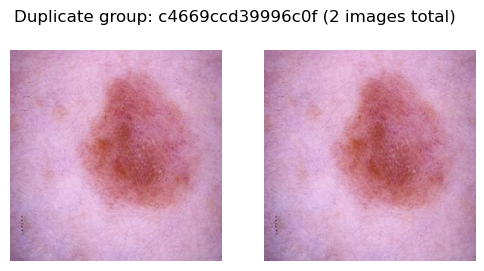

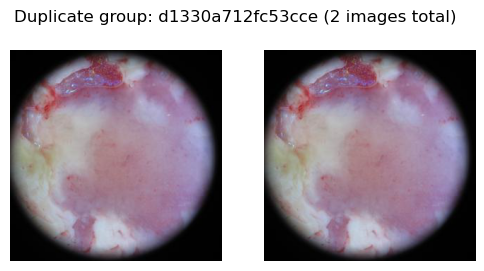

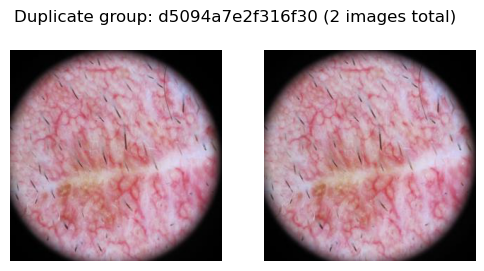

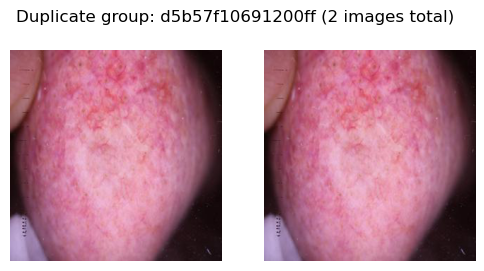

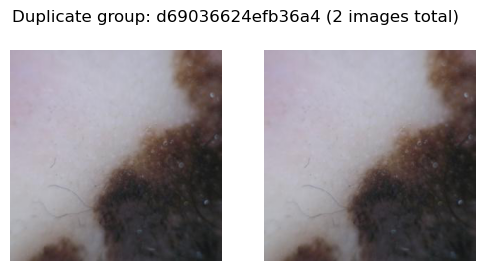

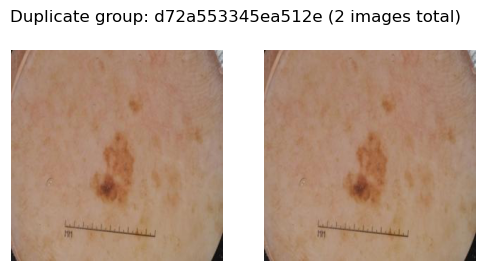

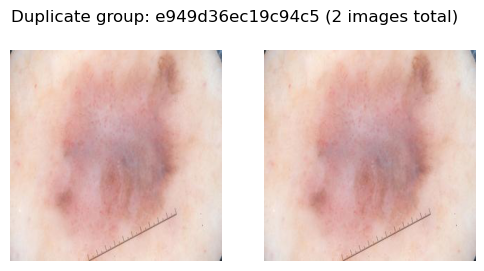

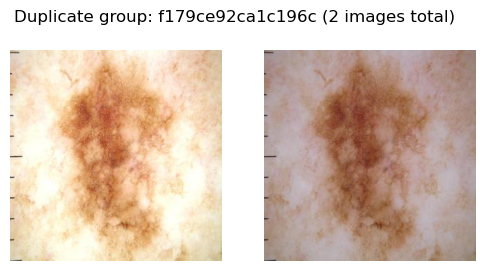

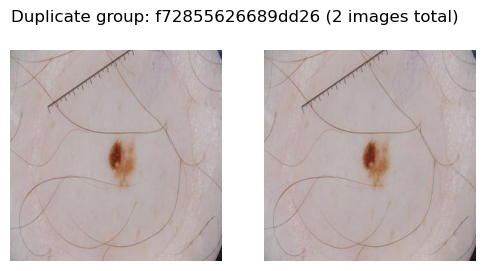

Removed 23 duplicate images (kept one per group).


In [29]:
from tqdm import tqdm
import imagehash
from PIL import Image

# Compute perceptual hashes
def compute_hash(fp):
    try:
        return str(imagehash.phash(Image.open(fp).convert('RGB').resize((128, 128))))
    except:
        return None

train_df['hash'] = [compute_hash(fp) for fp in tqdm(train_df['file_path'])]

# Find duplicates by hash
dupe_hashes = train_df[train_df.duplicated('hash', keep=False)]
dupe_counts = dupe_hashes['hash'].value_counts()
print(f"Found {dupe_counts[dupe_counts > 1].sum()} images with duplicate hash values.")

# Show samples of duplicates
def show_all_duplicates(df, max_per_group=5):
    from math import ceil

    dup_hashes = df[df.duplicated('hash', keep=False)]
    grouped = dup_hashes.groupby('hash')

    for hash_val, group in grouped:
        file_paths = group['file_path'].tolist()[:max_per_group]
        n = len(file_paths)
        fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
        for ax, fp in zip(axes, file_paths):
            ax.imshow(Image.open(fp))
            ax.axis('off')
        plt.suptitle(f"Duplicate group: {hash_val} ({len(group)} images total)")
        plt.show()

show_all_duplicates(train_df, max_per_group=5)

# Keep the first occurrence per hash, drop the rest
clean_df = train_df.drop_duplicates(subset='hash', keep='first').copy()

# Show how many were dropped
n_removed = len(train_df) - len(clean_df)
print(f"Removed {n_removed} duplicate images (kept one per group).")

### Dealing with border

In [14]:
def has_vignette_border(img_path, threshold=0.6):
    try:
        img = Image.open(img_path).convert("L").resize((128, 128))
        img_np = np.array(img)

        # Corner patches (10% size)
        patch_size = 13
        corners = [
            img_np[:patch_size, :patch_size],                    
            img_np[:patch_size, -patch_size:],                  
            img_np[-patch_size:, :patch_size],                  
            img_np[-patch_size:, -patch_size:]                  
        ]

        border_pixels = np.concatenate([c.flatten() for c in corners])
        # Count near-black or near-white pixels
        mask = (border_pixels < 30) | (border_pixels > 225)
        return np.mean(mask) > threshold
    except:
        return False

def show_border_samples(df, n=5):
    subset = df[df['has_vignette_border']].sample(n)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    for ax, fp in zip(axes, subset['file_path']):
        ax.imshow(Image.open(fp))
        ax.axis('off')
    plt.suptitle("Sample Images with Vignette Borders")
    plt.show()

In [30]:
clean_df['has_vignette_border'] = clean_df['file_path'].apply(has_vignette_border)

has_vignette_border
False    8229
True     1352
Name: count, dtype: int64


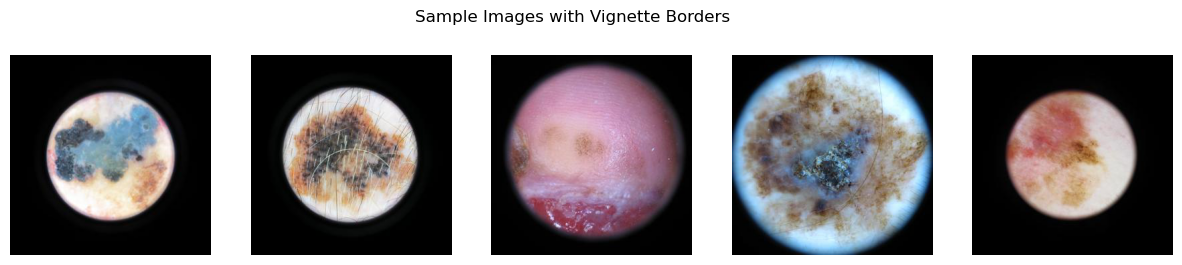

In [31]:
print(clean_df['has_vignette_border'].value_counts())
show_border_samples(clean_df, n=5)


In [ ]:
import cv2
import numpy as np
from PIL import Image

def crop_to_detected_circle(img_path, shrink=0.95):
    import cv2
    import numpy as np
    from PIL import Image

    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        return Image.open(img_path)  # fallback

    h, w = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)

    # Try HoughCircles
    try:
        circles = cv2.HoughCircles(
            gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=min(h, w)//2,
            param1=100, param2=30,
            minRadius=int(0.3 * min(h, w)),
            maxRadius=int(0.6 * min(h, w))
        )
    except cv2.error:
        circles = None

    if circles is not None:
        x, y, r = circles[0][0]
    else:
        # fallback: max contour enclosing circle
        edges = cv2.Canny(gray, 50, 150)
        cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if cnts:
            (x, y), r = cv2.minEnclosingCircle(max(cnts, key=cv2.contourArea))
        else:
            # fallback: center crop
            s = min(h, w)
            y1 = (h - s) // 2; x1 = (w - s) // 2
            crop = img_bgr[y1:y1+s, x1:x1+s]
            return Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))

    # Ensure values are standard int (not numpy.uint16)
    x, y, r = int(x), int(y), int(r * shrink)

    x1 = max(x - r, 0)
    y1 = max(y - r, 0)
    x2 = min(x + r, w)
    y2 = min(y + r, h)

    cropped = img_bgr[y1:y2, x1:x2]
    return Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))




In [37]:
clean_df['processed_img'] = clean_df.apply(
    lambda row: crop_to_detected_circle(row['file_path']) if row['has_vignette_border'] 
    else Image.open(row['file_path']), axis=1)

TypeError: Image data of dtype object cannot be converted to float

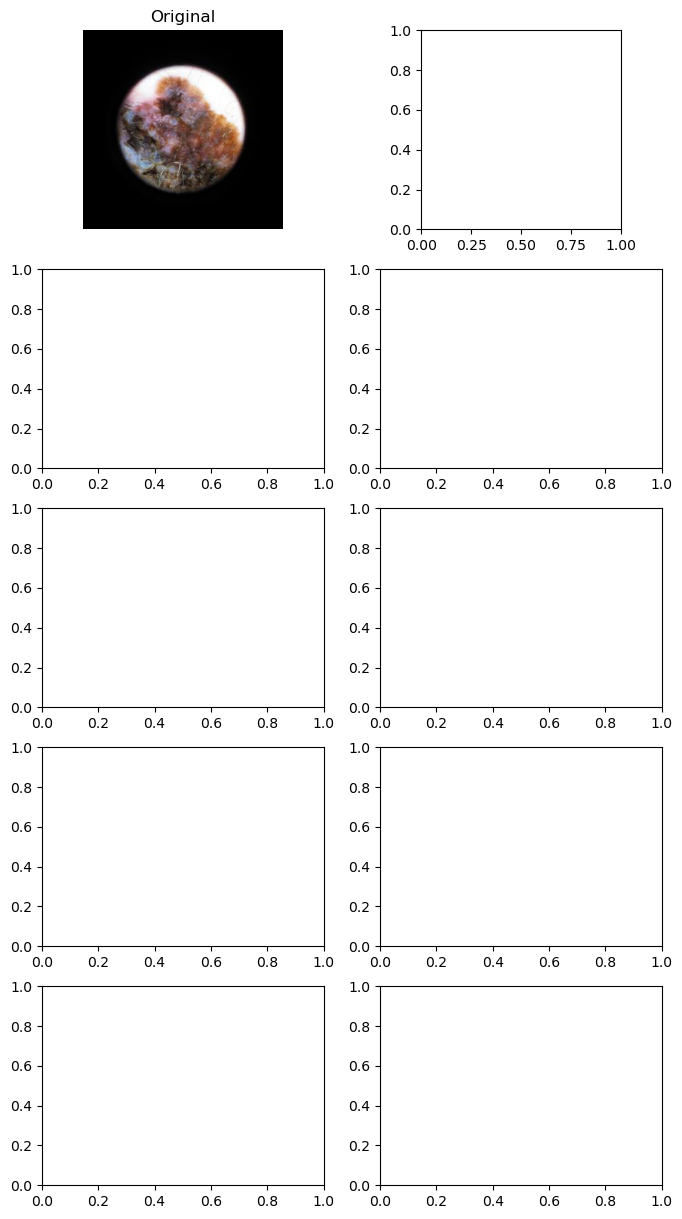

In [38]:
def show_before_after_crop(df, n=5):
    import matplotlib.pyplot as plt

    subset = df[df['has_vignette_border']].sample(n)
    
    fig, axes = plt.subplots(n, 2, figsize=(8, 3*n))
    for i, (_, row) in enumerate(subset.iterrows()):
        # Original
        orig = Image.open(row['file_path'])
        axes[i, 0].imshow(orig)
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        # Cropped
        cropped = crop_to_detected_circle(row['file_path'])
        axes[i, 1].imshow(cropped)
        axes[i, 1].set_title("Cropped")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
show_before_after_crop(clean_df, n=5)

# Model training

In [ ]:
def show_before_after_crop(df, n=5):
    import matplotlib.pyplot as plt

    subset = df[df['has_vignette_border']].sample(n)
    
    fig, axes = plt.subplots(n, 2, figsize=(8, 3*n))
    for i, (_, row) in enumerate(subset.iterrows()):
        # Original
        orig = Image.open(row['file_path'])
        axes[i, 0].imshow(orig)
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        # Cropped
        cropped = crop_to_circle_region(row['file_path'])
        axes[i, 1].imshow(cropped)
        axes[i, 1].set_title("Cropped")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


In [25]:
if tensorflow.test.is_gpu_available():
   print("GPU is avilable")
else:
   print("GPU is not available") 

print(tensorflow.config.list_physical_devices('GPU'))

GPU is not available
[]


In [59]:
# Sample dataset loading structure
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    validation_split=0.2)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip = True,
    brightness_range=[0.8, 1.2],
)

train_generator = train_datagen.flow_from_directory(
    path+'/melanoma_cancer_dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    path + '/melanoma_cancer_dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')  # 👈 key difference

Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.


In [68]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2, EfficientNetB1
from tensorflow.keras.callbacks import ReduceLROnPlateau


base_model = EfficientNetB0(weights='imagenet', 
                            include_top=False,
                            input_shape=(224, 224, 3))


# Phase 2: Later unfreeze some layers
base_model.trainable = False
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-200:]:  # Unfreeze the last 20 layers
    layer.trainable = True
    
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer (optional, can be replaced with Flatten)

# Step 2: Dense Layer with 128 hidden units and ReLU activation
x = Dense(128, activation='relu')(x)

# Step 3: Dropout layer with a 20% rate
x = Dropout(0.2)(x)

# Step 4: Final Dense layer with 1 output unit (sigmoid classifier)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=3e-6),  # Lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks to reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=3, 
                              min_lr=1e-6, 
                              verbose=1)

from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting if validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)



callbacks = [early_stopping, reduce_lr]
# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Increase epochs
    callbacks=callbacks
)



Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 213s 818ms/step - accuracy: 0.6281 - loss: 0.6492 - val_accuracy: 0.4779 - val_loss: 0.7062 - learning_rate: 3.0000e-06
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 192s 795ms/step - accuracy: 0.7567 - loss: 0.5248 - val_accuracy: 0.6679 - val_loss: 0.6353 - learning_rate: 3.0000e-06
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 189s 785ms/step - accuracy: 0.7907 - loss: 0.4559 - val_accuracy: 0.8142 - val_loss: 0.4152 - learning_rate: 3.0000e-06
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 190s 788ms/step - accuracy: 0.8046 - loss: 0.4279 - val_accuracy: 0.8433 - val_loss: 0.3629 - learning_rate: 3.0000e-06
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 186s 771ms/step - accuracy: 0.8099 - loss: 0.4090 - val_accuracy: 0.8631 - val_loss: 0.3347 - learning_rate: 3.0000e-06
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 187s 777ms/step - accuracy: 0.8323 - loss: 0.3767 - val_accuracy: 0.8771 - val_loss: 0.3152 - learning_rate: 3.0000e-06
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 

In [49]:
# Step 5: Unfreeze some or all layers of the base model for Phase 2 (fine-tuning)
base_model.trainable = True  # Unfreeze all layers, or you can freeze the first N layers

# Step 6: Recompile the model and continue training (fine-tuning)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history2 = model.fit(train_generator, epochs=10, validation_data=val_generator)  # Fine-tune the entire model


Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.6614 - loss: 0.6243 - val_accuracy: 0.4222 - val_loss: 0.6960
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.8639 - loss: 0.3304 - val_accuracy: 0.5471 - val_loss: 0.7516
Epoch 3/10
 77/241 ━━━━━━━━━━━━━━━━━━━━ 3:32 1s/step - accuracy: 0.8921 - loss: 0.2815

KeyboardInterrupt: 

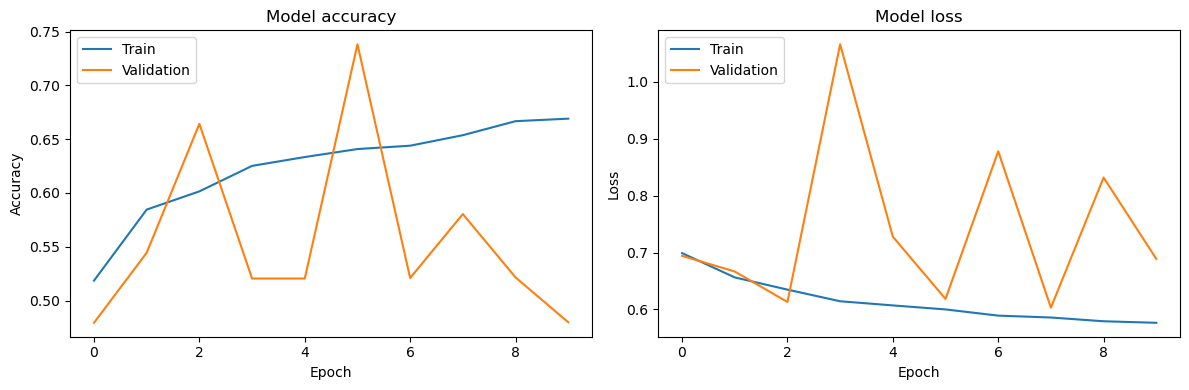

In [63]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Testing the model

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    path + '/melanoma_cancer_dataset/test',  # adjust to your actual test dir
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # important for matching predictions to labels
)


Found 1000 images belonging to 2 classes.


In [19]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_generator, verbose=1)

# Convert to class labels
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# True labels
y_true = test_generator.classes


/home/simon/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 523ms/step


In [20]:
from sklearn.metrics import (classification_report, confusion_matrix, 
                             matthews_corrcoef, f1_score, precision_score, 
                             recall_score, roc_auc_score)
import numpy as np

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)  # Sensitivity
specificity = tn / (tn + fp)
f1 = f1_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
gmean = np.sqrt(recall * specificity)

# Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Print all metrics
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score:   {f1:.4f}")
print(f"MCC:        {mcc:.4f}")
print(f"G-Mean:     {gmean:.4f}")



Classification Report:
              precision    recall  f1-score   support

      benign       0.75      0.91      0.82       500
   malignant       0.89      0.69      0.78       500

    accuracy                           0.80      1000
   macro avg       0.82      0.80      0.80      1000
weighted avg       0.82      0.80      0.80      1000

Accuracy:  0.8040
Precision: 0.8897
Recall (Sensitivity): 0.6940
Specificity: 0.9140
F1-Score:   0.7798
MCC:        0.6233
G-Mean:     0.7964


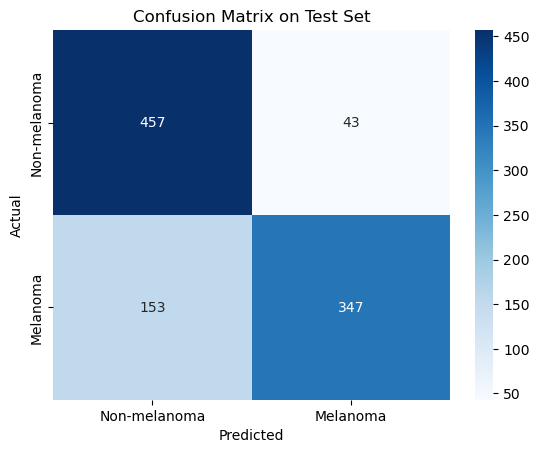

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-melanoma', 'Melanoma'],
            yticklabels=['Non-melanoma', 'Melanoma'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()
